# Earth Engine analysis

In [1]:
from urllib.request import urlopen
import zipfile
import rasterio
import json
import requests
from pprint import pprint
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import pandas as pd
import folium
import os
import ee

Initialize the Earth Engine client.

In [2]:
ee.Initialize()

In [3]:
image_name = 'users/iker/Resilience/total_carbon_africa'

In [4]:
geometry = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              15.1171875,
              2.5479878714713835
            ],
            [
              13.1396484375,
              -1.845383988573187
            ],
            [
              15.644531250000002,
              -4.696879026871413
            ],
            [
              21.708984375,
              -3.425691524418062
            ],
            [
              20.9619140625,
              1.3182430568620136
            ],
            [
              15.1171875,
              2.5479878714713835
            ]
          ]
        ]
      }
    }
  ]
}

r = json.dumps(geometry)
r = json.loads(r)

In [5]:
polygon = ee.Geometry.Polygon(r.get('features')[0].get('geometry').get('coordinates'))

In [6]:
image = ee.Image(image_name).clip(ee.Geometry(polygon))

**Inspect the data**

In [16]:
def show_image(image):
      display.display(display.Image(ee.data.getThumbnail({
      'image': image.serialize(),
      'dimensions': '360'
  })))

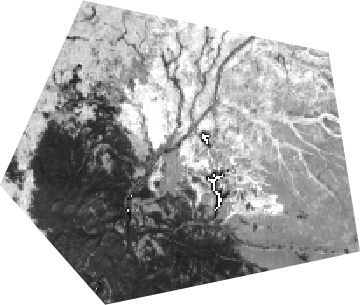

In [17]:
show_image(image.visualize(min=0,max=15000))

## Download data

In [18]:
def download_image(image):
    
    download_zip = 'data.zip'
    
    url = image.getDownloadUrl()     

    print('Downloading image...')
    print("url: ", url)
    data = urlopen(url)
    with open(download_zip, 'wb') as fp:
        while True:
            chunk = data.read(16 * 1024)
            if not chunk: break
            fp.write(chunk)
            
    # extract the zip file transformation data
    z = zipfile.ZipFile(download_zip, 'r')
    target_folder_name = download_zip.split('.zip')[0]
    z.extractall(target_folder_name)
    # remove directory
    os.remove(download_zip)
    print('Download complete!')

In [19]:
download_image(image)

url:  https://earthengine.googleapis.com/api/download?docid=1ba9fe9f153317bfc501b28e620b833d&token=dd983769351ab44c4fb1417b24c77c58
Download complete!


**Load data**

In [20]:
# Load tiff file data
with rasterio.open('./data/total_carbon_africa.b1.tif') as src:
    data = src.read()
    profile = src.profile
    transform = src.transform

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


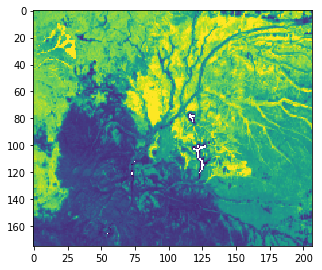

In [21]:
data[data==data.min()]=np.nan
fig, ax = plt.subplots(figsize=(5,5))

ax.imshow(data[0,:,:], vmax=15000);

### Google Cloud Function ([getting started](https://medium.com/@timhberry/getting-started-with-python-for-google-cloud-functions-646a8cddbb33))

To create a Google Cloud Function we need a [Google Cloud Project](https://cloud.google.com/resource-manager/docs/creating-managing-projects) and [gcloud SDK](https://cloud.google.com/sdk/docs/).

If we have already some projects we can check them by typing:

`gcloud projects list`
```
PROJECT_ID        NAME                     PROJECT_NUMBER
gef-ld-toolbox    gef-ld-toolbox           1080184168142
gfw-apis          Global Forest Watch API  872868960419
resource-watch    Resource Watch           312603932249
skydipper-196010  skydipper                230510979472
soc-platform      SOC Platform             345072612231
```
and select one by:

`gcloud config set project gef-ld-toolbox`

Then create a function by creating a `main.py` file with some python code on it:

```python
import ee
import json

service_account = 'gef-ldmp-server@gef-ld-toolbox.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, 'privatekey.json')
ee.Initialize(credentials)

def serializer(url):

    return {
        'download_url': url
    }
    
def download_image(request):
    request = request.get_json()
    
    polygon = ee.Geometry.Polygon(request['geometry'].get('features')[0].get('geometry').get('coordinates'))
    
    image = ee.Image(request['assetId']).clip(ee.Geometry(polygon))
    
    url = image.getDownloadUrl()
    
    return json.dumps(serialize_response(url))
```

In the same directory include the `privatekey.json` with the [service account keys](https://cloud.google.com/iam/docs/creating-managing-service-account-keys) and the `requirements.txt` file. 

Finally cd to that directory and deploy the cloud Function with the following command:

`gcloud beta functions deploy download_image --runtime python37 --trigger-http`

Note that the cloud function name matches the name of the function we defined in code: `download_image`.

In [5]:
import json
import requests
from pprint import pprint

In [6]:
payload = {
    "assetId": "projects/SPARC_team/Birds/total_carbon_africa",
    "geometry": {
        "type": "FeatureCollection",
        "features": [{
            "type": "Feature",
            "properties": {},
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [
                            15.1171875,
                            2.5479878714713835
                        ],
                        [
                            13.1396484375,
                            -1.845383988573187
                        ],
                        [
                            15.644531250000002,
                            -4.696879026871413
                        ],
                        [
                            21.708984375,
                            -3.425691524418062
                        ],
                        [
                            20.9619140625,
                            1.3182430568620136
                        ],
                        [
                            15.1171875,
                            2.5479878714713835
                        ]
                    ]
                ]
            }
        }
        ]
    }
}

In [ ]:
url = f'https://us-central1-gef-ld-toolbox.cloudfunctions.net/download_image'

headers = {'Content-Type': 'application/json'}

r = requests.post(url, data=json.dumps(payload), headers=headers)
pprint(r.json())

## Histogram

In [7]:
geometry = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              20.126953125,
              4.8282597468669755
            ],
            [
              16.083984375,
              -12.897489183755892
            ],
            [
              30.937499999999996,
              -17.392579271057766
            ],
            [
              38.49609375,
              -13.2399454992863
            ],
            [
              36.38671875,
              1.4939713066293239
            ],
            [
              20.126953125,
              4.8282597468669755
            ]
          ]
        ]
      }
    }
  ]
}

geometry = json.dumps(geometry)
geometry = json.loads(geometry)

In [8]:
image = ee.Image(image_name)

In [23]:
regReducer = {
    'collection': ee.FeatureCollection(geometry.get('features')),
    'reducer': ee.Reducer.histogram(maxBuckets= 20)
}

hist = image.reduceRegions(**regReducer).toList(10000).getInfo()

count = np.array(hist[0].get('properties').get('histogram').get('histogram'))
bucketWidth = hist[0].get('properties').get('histogram').get('bucketWidth')
x_min = np.arange(len(count))*bucketWidth
x_max = np.arange(len(count))*bucketWidth + bucketWidth

<BarContainer object of 24 artists>

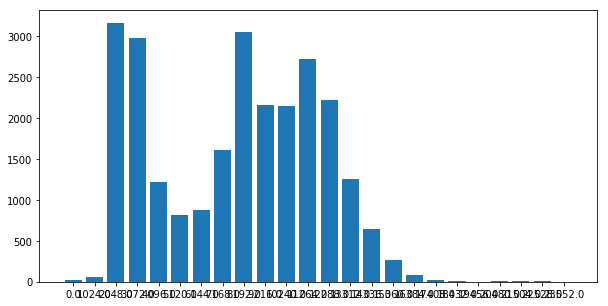

In [24]:
plt.figure(figsize=(10,5))

width = 0.35  
plt.bar(x_min.astype(np.str), count)

### Google Cloud Function ([getting started](https://medium.com/@timhberry/getting-started-with-python-for-google-cloud-functions-646a8cddbb33))

`main.py`

```python
import ee
import json
import numpy as np
import pandas as pd

service_account = 'gef-ldmp-server@gef-ld-toolbox.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, 'privatekey.json')
ee.Initialize(credentials)

def serializer(hist):

    bucketWidth = hist[0].get('properties').get('histogram').get('bucketWidth')    
    count = np.array(hist[0].get('properties').get('histogram').get('histogram'))
    x_min = np.arange(len(count))*bucketWidth
    x_max = np.arange(len(count))*bucketWidth + bucketWidth

    df = pd.DataFrame({'min': x_min, 'max': x_max, 'count': count, 'percent': count/count.sum()})
    
    return {'rows': df.to_dict(orient='record'),
            'fields': {
                'min': {'type': "number"},
                'max': {'type': "number"},
                'count': {'type': "number"},
                'percent': {'type': "number"}
            },
            'total_rows': len(count)
            }
    
def image_hist(request):
    request = request.get_json()
    
    image = ee.Image(request['assetId']).clip(ee.Geometry(polygon))
    
    regReducer = {
        'collection': ee.FeatureCollection(request['geometry'].get('features')),
        'reducer': ee.Reducer.histogram(maxBuckets= 20)
        }
    
    hist = image.reduceRegions(**regReducer).toList(10000).getInfo()
        
    return json.dumps(serializer(hist))
```

In [9]:
payload = {
    "assetId": "projects/SPARC_team/Birds/total_carbon_africa",
    "geometry": {
        "type": "FeatureCollection",
        "features": [{
            "type": "Feature",
            "properties": {},
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [
                          30.849609375,
                          -3.162455530237848
                        ],
                        [
                          35.33203125,
                          -3.162455530237848
                        ],
                        [
                          35.33203125,
                          0.4394488164139768
                        ],
                        [
                          30.849609375,
                          0.4394488164139768
                        ],
                        [
                          30.849609375,
                          -3.162455530237848
                        ]
                    ]
                ]
            }
        }
        ]
    }
}

In [10]:
%%time
url = f'https://us-central1-gef-ld-toolbox.cloudfunctions.net/histogram'

headers = {'Content-Type': 'application/json'}

r = requests.post(url, data=json.dumps(payload), headers=headers)
pprint(r.json())

{'fields': {'count': {'type': 'number'},
            'max': {'type': 'number'},
            'min': {'type': 'number'},
            'percent': {'type': 'number'}},
 'rows': [{'count': 153, 'max': 512, 'min': 0, 'percent': 0.02250439964906632},
          {'count': 157,
           'max': 1024,
           'min': 512,
           'percent': 0.02309274996668897},
          {'count': 213.66274509803927,
           'max': 1536,
           'min': 1024,
           'percent': 0.03142713598563962},
          {'count': 730.6666666666658,
           'max': 2048,
           'min': 1536,
           'percent': 0.10747199135240375},
          {'count': 1112.0000000000023,
           'max': 2560,
           'min': 2048,
           'percent': 0.16356138829909672},
          {'count': 1377.545098039219,
           'max': 3072,
           'min': 2560,
           'percent': 0.20261977399272438},
          {'count': 1147.9019607843138,
           'max': 3584,
           'min': 3072,
           'percent': 0.168

In [14]:
payload = {"assetId":"projects/SPARC_team/Birds/total_carbon_africa","geometry":{"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":{"type":"Polygon","coordinates":[[[18.500977,10.876465],[17.402344,9.838979],[16.21582,9.709057],[15.908203,9.362353],[16.083984,9.058702],[16.083984,8.798225],[15.380859,8.624472],[14.458008,8.711359],[14.326172,8.276727],[14.282227,7.449624],[13.842773,6.708254],[13.31543,6.926427],[12.963867,6.708254],[12.963867,5.922045],[13.227539,5.703448],[14.414063,5.659719],[14.326172,4.784469],[13.666992,4.740675],[13.359375,3.995781],[13.40332,3.469557],[13.974609,3.162456],[14.853516,3.118576],[14.80957,2.547988],[14.018555,2.24064],[13.447266,1.933227],[13.40332,1.493971],[13.447266,0.615223],[14.194336,0.527336],[14.985352,0.263671],[15.029297,-0.747049],[16.303711,-0.307616],[16.435547,2.108899],[16.831055,1.318243],[16.831055,0.57128],[16.831055,-0.439449],[16.655273,-0.747049],[15.46875,-1.537901],[14.106445,-1.493971],[13.710938,-1.933227],[13.710938,-3.250209],[14.370117,-3.688855],[16.259766,-4.696879],[16.743164,-3.294082],[18.808594,-4.872048],[17.885742,-3.513421],[19.191742,-3.688855],[19.543304,-2.196727],[18.752289,-1.889306],[19.367523,-0.922812],[20.114594,-2.372369],[20.378265,-3.908099],[20.070648,-4.696879],[19.499359,-5.484768],[18.312836,-5.965754],[17.09816,-6.993563],[19.288216,-7.38596],[20.914192,-6.86269],[22.05677,-6.51352],[25.264778,-4.63289],[24.078255,-3.931733],[27.330208,-3.010584],[26.407356,-2.132572],[28.165169,-1.166187],[25.253792,0.035706],[27.451057,0.56304],[29.077034,1.485734],[28.154182,1.705376],[26.879768,1.968912],[27.758675,2.759248],[29.648323,2.847033],[29.648323,3.987561],[32.197151,6.132362],[32.153206,7.267119],[31.933479,8.35554],[33.163948,8.442488],[33.911018,9.180736],[33.42762,10.090558],[32.109261,11.47195],[28.945198,11.945288],[28.022346,11.902291],[28.154182,11.170318],[27.978401,9.917449],[27.495003,8.876931],[27.05555,7.833452],[26.132698,8.485955],[25.078011,10.609319],[24.33094,11.428879],[20.490704,9.50663],[22.204571,11.58027],[21.018047,11.967456],[20.227032,11.408014],[19.523907,10.63159],[18.500977,10.876465]]]}}]}}

In [3]:
%%time
url = f'https://us-central1-gef-ld-toolbox.cloudfunctions.net/get_hist'

headers = {'Content-Type': 'application/json'}

r = requests.post(url, data=json.dumps(payload), headers=headers)
pprint(r.json())

{'fields': {'count': {'type': 'number'},
            'max': {'type': 'number'},
            'min': {'type': 'number'},
            'percent': {'type': 'number'}},
 'rows': [{'count': 39.72941176470588,
           'max': 1024.0,
           'min': 0.0,
           'percent': 0.00029550090465978743},
          {'count': 19997.29803921571,
           'max': 2048.0,
           'min': 1024.0,
           'percent': 0.14873665123300833},
          {'count': 33570.447058823534,
           'max': 3072.0,
           'min': 2048.0,
           'percent': 0.24969152663187674},
          {'count': 19517.890196078475,
           'max': 4096.0,
           'min': 3072.0,
           'percent': 0.14517089364799668},
          {'count': 6683.709803921567,
           'max': 5120.0,
           'min': 4096.0,
           'percent': 0.04971234674299576},
          {'count': 4037.4235294117643,
           'max': 6144.0,
           'min': 5120.0,
           'percent': 0.030029699722253632},
          {'count': 407

In [6]:
url = f'https://us-central1-gef-ld-toolbox.cloudfunctions.net/download_image'

headers = {'Content-Type': 'application/json'}

r = requests.post(url, data=json.dumps(payload), headers=headers)
pprint(r.json())

{'download_url': 'https://earthengine.googleapis.com/api/download?docid=ecbf83dbf52ed6decc7a115bbbb1f23b&token=3ca1344193855b47273626a90ab59844'}
